<a href="https://colab.research.google.com/github/badri449/BTechProject/blob/master/F_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import math
from sklearn.datasets import make_blobs
# from training_data import *
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, mixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import Normalizer
from numpy import linalg as LA


TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sb.set()
tf.reset_default_graph()


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(X,Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        
        h_11 = tf.layers.dense(X,16)
        h_12 = tf.layers.dense(h_11,16)
        h_13 = tf.layers.dense(h_12,20)

        h_21 = tf.layers.dense(Z,16)
        h_22 = tf.layers.dense(h_21,16)
        h_23 = tf.layers.dense(h_22,16)
        
        Z = tf.concat([h_11,h_23],1)
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,16)
        out = tf.layers.dense(h3,100)
        # print("hello",out.shape)
    return (out,h_13)

def discriminator(X,Y,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h_11 = tf.layers.dense(X,16)
        h_12 = tf.layers.dense(h_11,16)
        h_13 = tf.layers.dense(h_12,16)

        h_21 = tf.layers.dense(Y,16)
        h_22 = tf.layers.dense(h_21,16)
        h_23 = tf.layers.dense(h_22,16)

        X = tf.concat([h_13,h_23],1)
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,16,activation=tf.nn.leaky_relu)
        h4 = tf.layers.dense(h3,2)
        out = tf.layers.dense(h4,1)

    return out, h4

def encoder(X,Z,input_dim,hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/encoder",reuse=reuse):
        X = tf.concat([X,Z],1)
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,16)
        out = tf.layers.dense(h3,input_dim)
    return out



In [0]:
batch_size = 512
nd_steps = 10
ng_steps = 10
x_dim = 10
z_dim = 6
X = tf.placeholder(tf.float64,[batch_size,x_dim],name='X')
Y = tf.placeholder(tf.float64,[batch_size,1],name='Y')
Z = tf.placeholder(tf.float64,[batch_size,z_dim],name='Z')


beta_dis = tf.placeholder(tf.float64,[1,1])
beta_gen = 0.8
beta_hot = 10


input_dim = 1

(G_sample_temp,X_GAN) = generator(X,Z)
G_sample = tf.reshape(tf.reduce_mean(G_sample_temp,axis=1),[batch_size,1])
r_logits, r_rep = discriminator(X,Y)
f_logits, g_rep = discriminator(X,G_sample,reuse=True)

X_gen = encoder(G_sample_temp,sample_Z(batch_size,25),input_dim,reuse=False)
# X_gen = Z_enc[:,0:1]
# Z_gen = Z_enc[:,1:]

disc_loss_r = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)))
disc_loss_f = beta_dis[0][0]*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))
          # tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
# gen_loss = 2.5*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))+\
            # beta_gen *tf.reduce_mean(tf.square(X_gen - X))
            # beta_hot*tf.reduce_mean(tf.square(Z_gen - Z))


gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize((disc_loss_r+disc_loss_f),var_list = disc_vars) # D Train step

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
class_1=[]   #LinearRegression X Y
class_2=[]   #LinearRegression X_Noise Y_Noise
class_3=[]   #GAN X Y
class_4=[]   #GAN X_Noise Y_Noise
class_4_q=[]
class_4_r=[]
Iteration = []
N_range=[]
test_size = 0.33
for N in [100,500,1000,1500,2000,3000]:
  N_range.append(N)
  D = 10
  data1 = make_regression(n_samples=N, n_features=D, n_informative=2, n_targets=1, 
                      bias=0.0, effective_rank=None,tail_strength=0.5, 
                      noise=0.0, shuffle=True, coef=False, random_state=None)
  (x,y)=data1
  y = y.reshape(N,1)

  transformer = Normalizer().fit(x)   #Normalization of X
  x = transformer.transform(x)
  x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=test_size, random_state=42)

  # Calculating Y_Max and Y_min such that 90% data comes between Y_Max and Y_min
  ts=y_train.copy()
  ts.sort(axis=0)
  y_min = ts[int(N*test_size*0.05)]
  y_max = ts[int(N*test_size*0.95)]
  for x in range(y_train.shape[0]):
    if y_train[x]<y_min:y_train[x]=y_min
    elif y_train[x]>y_max:y_train[x]=y_max

  #Adding Laplacian Noise to training data
  # b=(N*D)/2
  loc, scale = 0., (x_train.shape[0]*D)/20
  noise = np.random.laplace(loc, scale, x_train.shape[0]*D).reshape(x_train.shape[0],D)
  xn_train = x_train + noise
  
  xn_test = x_test.copy()

  #Adding Laplacian Noise to training data for Y
  # b=(N*(Y_Max - Y_min)
  loc, scale = 0., (y_train.shape[0]*(y_max-y_min))
  noise = np.random.laplace(loc, scale, y_train.shape[0]*1).reshape(y_train.shape[0],1)
  # loc, scale = 0., (x_train.shape[0]*D)/2
  # noise = np.random.laplace(loc, scale, y_train.shape[0]*1).reshape(y_train.shape[0],1)
  yn_train = y_train + noise

  yn_test = y_test.copy()

  # Linear regression for class_1 i.e without error
  X_train = x_train
  Y_train = y_train
  X_test = x_test
  Y_test = y_test
  regression_model = LinearRegression()
  regression_model.fit(X_train,Y_train)
  y_predicted = regression_model.predict(X_test)
  MAE = mean_absolute_error(Y_test , y_predicted)
  class_1.append(MAE)

  # Linear regression for class_2 with error
  X_train = xn_train
  Y_train = yn_train
  X_test = xn_test
  Y_test = yn_test
  regression_model = LinearRegression()
  regression_model.fit(X_train,Y_train)
  y_predicted = regression_model.predict(X_test)
  MAE = mean_absolute_error(Y_test , y_predicted)
  class_2.append(MAE)

  for class_v in [4]:
    if class_v==3:        # GAN for data without noise
      X_train = x_train
      Y_train = y_train
      X_test = x_test
      Y_test = y_test
    else:                 # GAN for data with noise
      X_train = xn_train
      Y_train = yn_train
      X_test = xn_test
      Y_test = yn_test
    sess = tf.Session()
    tf.global_variables_initializer().run(session=sess)
    itr = 0
    min_val = math.inf
    for i in range(10001):
      # Training the discriminator and generator from train data of batch size choosen randomly from train data
      index = np.random.randint(X_train.shape[0])
      X_batch = X_train[index]
      l=[Y_train[index]]
      # After 200 iterations update the parameters for discriminator loss function
      if(i>=200):var=np.array([1.5]).reshape(1,1)
      else:var=np.array([1]).reshape(1,1)
      for _ in range(batch_size-1):
        index = np.random.randint(X_train.shape[0])
        X_batch = np.concatenate((X_batch,X_train[index]))
        l.append(Y_train[index])
      noise = sample_Z(batch_size,1)
      Y_batch=np.array(l).reshape(batch_size,1) 
      X_batch = X_batch.reshape(batch_size,x_dim)
      Z_batch = sample_Z(batch_size, z_dim)
      for _ in range(nd_steps):
          _, r_dloss,f_dloss = sess.run([disc_step, disc_loss_r,disc_loss_f], feed_dict={X: X_batch,Z: Z_batch,Y:Y_batch, beta_dis : var})
      rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch,Y:Y_batch})

      for _ in range(ng_steps):
          _, gloss = sess.run([gen_step, gen_loss], feed_dict={X: X_batch, Z: Z_batch})

      rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch,Y:Y_batch})

      # Run Generator for the test data of batch size which are chosen randomly from test data
      index = np.random.randint(X_test.shape[0])
      X_Tbatch = X_test[index]
      l=[Y_test[index]]
      for _ in range(batch_size-1):
        index = np.random.randint(X_test.shape[0])
        X_Tbatch = np.concatenate((X_Tbatch,X_test[index]))
        l.append(Y_test[index])
    
      Y_Tbatch=np.array(l).reshape(batch_size,1)
      X_Tbatch = X_Tbatch.reshape(batch_size,x_dim)
      (g_plot,X_Modi) = sess.run([G_sample,X_GAN], feed_dict={X: X_Tbatch,Z: Z_batch})
      MAE = mean_absolute_error(Y_Tbatch , g_plot)
      #Update min MAE value and save the iteration at which it occurs  
      if(min_val>=MAE and i>500):
        min_val = MAE
        itr = i

        index = np.random.randint(X_train.shape[0])
        X_Tbatch = X_train[index]
        X_Original = x_train[index]
        l_Original = [y_train[index]]
        l=[Y_train[index]]
        for _ in range(batch_size-1):
          index = np.random.randint(X_train.shape[0])
          X_Tbatch = np.concatenate((X_Tbatch,X_train[index]))
          X_Original = np.concatenate((X_Original,x_train[index]))
          l_Original.append(y_train[index])
          l.append(Y_train[index])

        Y_Tbatch=np.array(l).reshape(batch_size,1)
        Y_Original=np.array(l_Original).reshape(batch_size,1)
        X_Original = X_Original.reshape(batch_size,x_dim)
        X_Tbatch = X_Tbatch.reshape(batch_size,x_dim)
        (g_plot,X_Modi) = sess.run([G_sample,X_GAN], feed_dict={X: X_Tbatch,Z: Z_batch})
    
        class4_X_O=X_Original
        class4_Y_O=Y_Original
        class4_X_N=X_Tbatch
        class4_Y_N=Y_Tbatch
        class4_X_GAN = X_Modi
        class4_Y_GAN = g_plot
    if class_v  == 3:
      class_3.append(min_val)
      print("done3")
    else:
      class_4.append(min_val)
      # class_6.append(min_val_o)
      Q = (LA.norm(x_train) - LA.norm(xn_train))**2
      R = (LA.norm(y_train) - LA.norm(yn_train))**2
      class_4_q.append(Q)
      class_4_r.append(R)
      Iteration.append((itr,N))
      print("done4")
    sess.close()
  print("Done for N = ",N)



done4
Done for N =  100
done4
Done for N =  500
done4
Done for N =  1000
done4
Done for N =  1500
done4
Done for N =  2000
done4
Done for N =  3000


In [0]:
print(class_2)  # MAE of LR for X_noise and  Y_noise
print(class_4)  # MAE of GAN for X_noise and  Y_noise

[1590.040203885352, 5668.851593736856, 11745.85794780278, 10805.910974387432, 4774.135544592814, 7686.305168902233]
[901.7493403436231, 24414.36399142567, 279.22276068858474, 676.8647820729202, 415.24213255728046, 230.7858765116489]


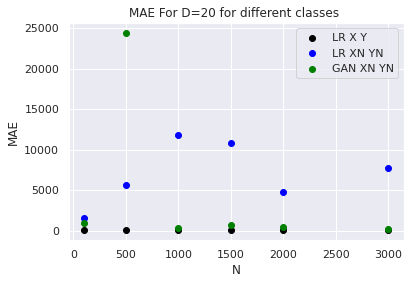

In [0]:
plt.figure()
plt.scatter(N_range,class_1,color = 'black',label="LR X Y")
plt.scatter(N_range,class_2,color = 'blue',label="LR XN YN")
# plt.scatter(N_range,class_3,color = 'orange',label="GAN X Y")
plt.scatter(N_range,class_4,color = 'green',label="GAN XN YN")
# plt.scatter(N_range,class_5,color = 'orange',label="LR XN YN O")
# plt.scatter(N_range,class_6,color = 'Red',label="GAN XN YN O")

plt.title("MAE For D=20 for different classes ")
plt.xlabel("N")
plt.ylabel("MAE")
plt.legend()
# plt.scatter(X_batch,g_batch,color='blue')
plt.show()
plt.close()

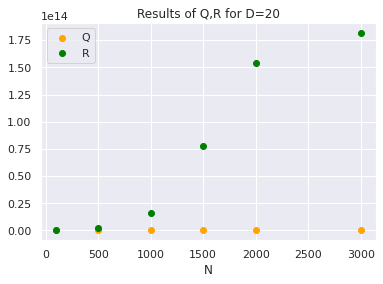

In [0]:
plt.figure()
plt.scatter(N_range,class_4_q,color = 'orange',label="Q")
plt.scatter(N_range,class_4_r,color = 'green',label="R")
plt.title("Results of Q,R for D=20")
plt.xlabel("N")
plt.legend()
# plt.scatter(X_batch,g_batch,color='blue')
plt.show()
plt.close()

In [0]:
print(class_4_q)
print(class_4_r)

[1595252.5595068366, 197276689.05203027, 1473115441.5694752, 4937544998.459577, 12258869811.718904, 40260460886.063545]
[15119067832.095129, 2433881871311.966, 16090162148452.88, 77817726135430.25, 154025905148999.47, 181811849694274.6]


In [0]:
print(itr,class_v,X_test.shape,Y_test.shape,y_train.shape,yn_train.shape,x_train.shape,xn_train.shape,y.shape)

6314 4 (990, 10) (990, 1) (2010, 1) (2010, 1) (2010, 10) (2010, 10) (3000, 1)


In [0]:
print(Iteration)  # Iterations at which MAE of GAN for X_noise and Y_noise is minimum
# Format (Iteration,N)

[(884, 100), (3218, 500), (3347, 1000), (9733, 1500), (9993, 2000), (6314, 3000)]


In [0]:
print(class_4)
# print(class_6)
# class4_X_O=X_Original
#         class4_Y_O=Y_Original
#         class4_X_N=X_Tbatch
#         class4_Y_N=Y_Tbatch
#         class4_X_GAN = X_Modi
#         class4_Y_GAN = g_plot
# print(class4_X_O,class4_Y_O,class4_Y_N,class4_X_GAN,class4_Y_GAN)

[901.7493403436231, 24414.36399142567, 279.22276068858474, 676.8647820729202, 415.24213255728046, 230.7858765116489]


In [0]:
# class4_X_O=X_Original
# class4_Y_O=Y_Original
# class4_X=X_Tbatch
# class4_Y=Y_Tbatch
# class4_X_GAN = X_Modi
# class4_Y_GAN = g_plot
# print(class4_Y_GAN-class4_Y)
# Linear regression for class_1 i.e without error
# X_train = x_train
# Y_train = y_train
# X_test = x_test
# Y_test = y_test
# regression_model = LinearRegression()
# regression_model.fit(X_train,Y_train)
# y_predicted = regression_model.predict(X_test)
# MAE = mean_absolute_error(Y_test , y_predicted)
# class_1.append(MAE)
regression_model = LinearRegression()
regression_model.fit(x_train,y_train)
yG_predicted = regression_model.predict(class4_X_GAN)
yO_predicted = regression_model.predict(class4_X_O)
yN_predicted = regression_model.predict(class4_X_N)
MAE = mean_absolute_error(class4_Y_GAN , yG_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yO_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_N , yN_predicted)
print(MAE)

MAE = mean_absolute_error(class4_Y_O , yG_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yO_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yN_predicted)
print(MAE)

regression_model = LinearRegression()
regression_model.fit(xn_train,yn_train)
yG_predicted = regression_model.predict(class4_X_GAN)
yO_predicted = regression_model.predict(class4_X_O)
yN_predicted = regression_model.predict(class4_X_N)
MAE = mean_absolute_error(class4_Y_GAN , yG_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yO_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_N , yN_predicted)
print(MAE)

MAE = mean_absolute_error(class4_Y_O , yG_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yO_predicted)
print(MAE)
MAE = mean_absolute_error(class4_Y_O , yN_predicted)
print(MAE)

MAE = mean_absolute_error(class4_X_GAN , class4_X_N)
print(MAE)

MAE = mean_absolute_error(class4_X_GAN , class4_X_O)
print(MAE)


ValueError: ignored